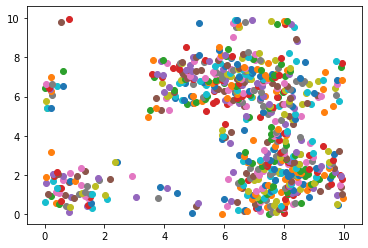

In [9]:
'''
ASTP-720, Fall 2020
Homework 5
Zach Diermyer
Problem 1
'''

import numpy as np
import matplotlib.pyplot as plt

def CoM(coords, m):
    '''
    Finds the center of mass of particles at each coordinate in the given arrays
    Inputs:
        coords - Array of [x, y] tuples/distances to each particle
        m - Array of particle masses
    Returns:
    '''
    totx = 0
    toty = 0
    totm = 0
    for i in range(len(coords)):
        totx += (m[i]*coords[i][0])
        toty += (m[i]*coords[i][1])
        totm += m[i]
    comx = totx/totm
    comy = toty/totm
    return(comx, comy)

def BarnesHut(box, Lc):
    quads = [[], [], [], [], Lc]
    for i in range(len(box)):
        if box[i][1] < Lc:
            if box[i][0] < Lc:
                quads[0].append(box[i])
            else:
                quads[1].append(box[i])
        else:
            if box[i][0] > Lc:
                quads[2].append(box[i])
            else:
                quads[3].append(box[i])
    for i in range(len(quads)):
        if len(quads[i]) > 1:
            quads[i] = BarnesHut(quads[i], Lc/2)
    return(quads)

def verlet(coords, prevcoords, m, h):
    G = 4.30091e-3     #In solar units
    a = []
    for i in range(len(coords)):
        aix = 0
        aiy = 0
        for j in range(len(coords)):
            if j == i:
                pass
            else:
                diffx = coords[i][0]-coords[j][0]
                diffy = coords[i][1]-coords[j][1]
                aix += G*m[j]*(diffx/(diffx**3))
                aiy += G*m[j]*(diffy/(diffy**3))
        a.append([aix, aiy])
    newcoords = []
    for i in range(len(coords)):
        xi1 = 2*coords[i][0] - prevcoords[i][0] + (h**2)*(a[i][0])
        yi1 = 2*coords[i][1] - prevcoords[i][1] + (h**2)*(a[i][1])
        newcoords.append([xi1, yi1])
    return(newcoords)

def forcesoften():
    return()

def main():
    start = np.load('galaxies0.npy')
    step1 = np.load('galaxies1.npy')
    plt.figure(1)
    for i in range(len(start)):
        plt.scatter(x = start[i][0], y = start[i][1])
        
main()


In [ ]:
'''
ASTP-720, Fall 2020
Homework 5
Zach Diermyer
Problem 2
'''

import numpy as np
import matplotlib.pyplot as plt


def main():
    M1 = 400*10e12
    M2 = 255*10e12
    V1 = (4/3)*np.pi*(3**3)
    V2 = (4/3)*np.pi*(2**3)
    rho1 = M1/V1
    rho2 = M2/V2
    
main()